# Inverted Pendulum
This code is based on [the inverted pendulum example](https://github.com/stack-of-tasks/pinocchio/blob/master/examples/simulation-inverted-pendulum.py) provided by the [Pinocchio](https://stack-of-tasks.github.io/pinocchio/) library. The goal is to balance a pendulum in the upright position by applying a torque to the joint.

The state of the system $x=[\theta\:\:\:\dot{\theta}]$ is described by the angle of the pendulum $\theta$ and its angular velocity $\dot{\theta}$. The control input $u$ is the torque applied to the joint.

In [1]:
import math
import sys
import time
from matplotlib import pyplot as plt

import hppfcl as fcl
import numpy as np
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer

import meshcat

import ilqr

In [2]:
Nb_pendulum = 1  # number of pendulums
model = pin.Model()
geom_model = pin.GeometryModel()

parent_id = 0
joint_placement = pin.SE3.Identity()
body_mass = 1.0
body_radius = 0.1

shape0 = fcl.Sphere(body_radius)
geom0_obj = pin.GeometryObject("base", 0, shape0, pin.SE3.Identity())
geom0_obj.meshColor = np.array([1.0, 0.1, 0.1, 1.0])
geom_model.addGeometryObject(geom0_obj)

/tmp/ipykernel_21591/2926480844.py:11: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  geom0_obj = pin.GeometryObject("base", 0, shape0, pin.SE3.Identity())


0

In [3]:
for k in range(Nb_pendulum):
    joint_name = "joint_" + str(k + 1)
    joint_id = model.addJoint(
        parent_id, pin.JointModelRY(), joint_placement, joint_name
    )

    body_inertia = pin.Inertia.FromSphere(body_mass, body_radius)
    body_placement = joint_placement.copy()
    body_placement.translation[2] = 1.0
    model.appendBodyToJoint(joint_id, body_inertia, body_placement)

    geom1_name = "ball_" + str(k + 1)
    shape1 = fcl.Sphere(body_radius)
    geom1_obj = pin.GeometryObject(geom1_name, joint_id, shape1, body_placement)
    geom1_obj.meshColor = np.ones(4)
    geom_model.addGeometryObject(geom1_obj)

    geom2_name = "bar_" + str(k + 1)
    shape2 = fcl.Cylinder(body_radius / 4.0, body_placement.translation[2])
    shape2_placement = body_placement.copy()
    shape2_placement.translation[2] /= 2.0

    geom2_obj = pin.GeometryObject(geom2_name, joint_id, shape2, shape2_placement)
    geom2_obj.meshColor = np.array([0.0, 0.0, 0.0, 1.0])
    geom_model.addGeometryObject(geom2_obj)

    parent_id = joint_id
    joint_placement = body_placement.copy()


visual_model = geom_model
viz = MeshcatVisualizer(model, geom_model, visual_model)

/tmp/ipykernel_21591/569758454.py:14: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  geom1_obj = pin.GeometryObject(geom1_name, joint_id, shape1, body_placement)
/tmp/ipykernel_21591/569758454.py:23: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  geom2_obj = pin.GeometryObject(geom2_name, joint_id, shape2, shape2_placement)


In [4]:
visual_model = geom_model
viz = MeshcatVisualizer(model, geom_model, visual_model)

# Initialize the viewer.
try:
    viz.initViewer(loadModel=True, viewer=meshcat.Visualizer())
except ImportError as err:
    print(
        "Error while initializing the viewer. "
        "It seems you should install gepetto-viewer"
    )
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print(
        "Error while loading the viewer model. "
        "It seems you should start gepetto-viewer"
    )
    print(err)
    sys.exit(0)

q = pin.neutral(model)
viz.display(q)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [5]:
# initial state
q0 = np.array([np.pi] * model.nq)
v0 = np.zeros(model.nv)
viz.display(q)

In [23]:
dt = 0.01
T = 5
N = math.floor(T / dt)

model.lowerPositionLimit.fill(-math.pi)
model.upperPositionLimit.fill(+math.pi)

data_sim = model.createData()

# we define a dynamics function to pass the solver
def dynamics(x, u):
    q, v = x[:model.nq], x[model.nq:]

    # apply the ABA algorithm to compute the acceleration
    a = pin.aba(model, data_sim, q, v, u)

    # integrate the acceleration to get the new state
    v += a * dt
    q = pin.integrate(model, q, v * dt)

    return np.concat((q, v))


def compute_jac(x, u):
    q, v = x[:model.nq], x[model.nq:]

    a = pin.aba(model, data_sim, q, v, u)
    new_v = v + a * dt

    J1_q, J1_v, J1_u = pin.computeABADerivatives(model, data_sim, q, v, u)
    J2_q, J2_v_prim = pin.dIntegrate(model, q, new_v * dt)

    dnew_v_dq = J1_q * dt
    dnew_v_dv = np.eye(model.nv) + J1_v * dt
    dnew_v_du = J1_u * dt

    dnew_q_dq = J2_q + J2_v_prim @ dnew_v_dq * dt
    dnew_q_dv = J2_v_prim @ dnew_v_dv * dt
    dnew_q_du = J2_v_prim @ dnew_v_du * dt

    jac_x = np.block([[dnew_q_dq, dnew_q_dv], [dnew_v_dq, dnew_v_dv]])
    jac_u = np.vstack((dnew_q_du, dnew_v_du))

    return jac_x, jac_u

state_dim = model.nq + model.nv
control_dim = model.nq

Q = np.zeros((state_dim, state_dim)) # state cost
Qf = np.eye(state_dim) # final state cost
R = np.zeros((control_dim, control_dim)) # control cost
if Nb_pendulum == 1:
    R = 1e-5 * np.eye(control_dim) # control cost (minimize the energy)
elif Nb_pendulum == 2:
    R = 1e-5 * np.eye(control_dim)
else:
    # avoid divergence
    Qf = 10 * Qf
    R = 1e-3 * np.eye(control_dim)

s = ilqr.ILQRSolver(state_dim, control_dim, Q, Qf, R)

target = np.zeros(state_dim) # target state, upright pendulum with no velocity
output = s.solve(np.concatenate((q0, v0)), target, dynamics, time_steps=N, jacobians=compute_jac,
                  gradient_clip=10.0, max_iterations=100, initialization=0.5, gradient_threshold=0.01, full_output=True)

print(f"Solution Kind: {output['kind']}")
print(f"Time Taken: {output['time_taken']}")
print(f"Iteration Needed: {output['it_taken']}")

Solution Kind: converged
Time Taken: 0.920643394
Iteration Needed: 38


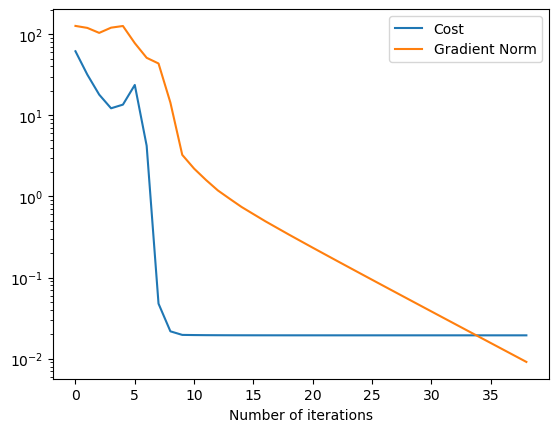

In [24]:
nb_it = len(output['cost'])

plt.semilogy(np.arange(nb_it), output['cost'], label='Cost')
plt.semilogy(np.arange(nb_it), output['gradient_norm'], label='Gradient Norm')
plt.legend()
plt.xlabel("Number of iterations")
plt.show()

In [25]:
t = 0.0

q = q0
v = v0

viz.display(q0)

for k in range(N):
    tic = time.time()

    tau_control = output['control'][k]
    x = dynamics(np.concat((q, v)), tau_control)
    q, v = x[:model.nq], x[model.nq:]

    viz.display(q)

    toc = time.time()
    elapsed = toc - tic
    dt_sleep = max(0, dt - elapsed)

    time.sleep(dt_sleep)
    t += dt

In [26]:
print(f"Final q: {q}")
print(f"Target q: {target[:model.nq]}")
print()
print(f"Final v: {v}")
print(f"Target v: {target[model.nq:]}")
print()
print(f"Error: {np.linalg.norm(target - x):.5f}")

Final q: [0.00644704]
Target q: [0.]

Final v: [-0.00196404]
Target v: [0.]

Error: 0.00674
